[View in Colaboratory](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb)

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Compositional Pattern Producing Networks for Feature Visualization

This notebook uses [**Lucid**](https://github.com/tensorflow/lucid) to produce aesthetically pleasing feature visualizations using a [Differentiable Image Parameterization](https://distill.pub/2018/differentiable-parameterizations/#section-xy2rgb) called a **Compositional Pattern Producing Network** (CPPN).

![](https://storage.googleapis.com/tensorflow-lucid/notebooks/xy2rgb/cppn-header.jpg)

This notebook additionally demonstrates:

* rendering videos of the training process of the CPPN generating the visualizations,
* rendering videos of interpolating between sets of learned CPPN parameters
* rendering high resolution visualizations from a set of CPPN parameters.


This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, and load a model

In [ ]:
%tensorflow_version 1.x

In [0]:
!pip install -q lucid>=0.2.3

In [0]:
# For video rendering

!pip install -q moviepy
!imageio_download_bin ffmpeg

Ascertaining binaries for: ffmpeg.
Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)663552/45929032 bytes (1.4%)1867776/45929032 bytes (4.1%)3637248/45929032 bytes (7.9%)6168576/45929032 bytes (13.4%)9486336/45929032 bytes (20.7%)12820480/45929032 bytes (27.9%)16310272/45929032 bytes (35.5%)19849216/45929032 bytes (43.2%)23289856/45929032 bytes (50.7%)26828800/45929032 bytes (58.4%)30261248/45929032 bytes (65.9%)33767424/45929032 bytes (73.5%)

In [1]:
from __future__ import print_function
import io
import string
import numpy as np
import PIL
import base64
from glob import glob

import matplotlib.pylab as pl

import tensorflow as tf
from tensorflow.contrib import slim

from IPython.display import clear_output, Image, display, HTML

import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


from google.colab import files

In [2]:
from lucid.modelzoo import vision_models
from lucid.misc.io import show, save, load
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session

In [3]:
model = vision_models.InceptionV1()
model.load_graphdef()

## Setting up the CPPN 

In [4]:
def composite_activation(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
  return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
  x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
  return (x-0.40)/0.58


def image_cppn(
    size,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
  r = 3.0**0.5  # std(coord_range) == 1.0
  coord_range = tf.linspace(-r, r, size)
  y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
  net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension

  with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
    for i in range(num_layers):
      in_n = int(net.shape[-1])
      net = slim.conv2d(
          net, num_hidden_channels,
          # this is untruncated version of tf.variance_scaling_initializer
          weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
      )
      if normalize:
        net = slim.instance_norm(net)
      net = activation_fn(net)

    rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
  return rgb

Estimating the number of parameters of CPPN.

In [36]:
with tf.Graph().as_default():
  image_cppn(224)
  variables = tf.get_collection('variables')
  param_n = sum([v.shape.num_elements() for v in variables])
  print('CPPN parameter count:', param_n)

CPPN parameter count: 8451


Let's quickly sanity check that this CPPN can learn to produce an image with the properties we expect it to.
As a simplistic test we try to fit the XOR function by imposing a loss on four corner points of the image.


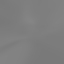
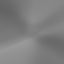
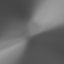
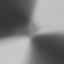
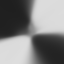
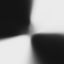
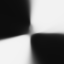
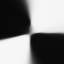
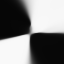
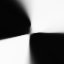

In [0]:
cppn_f = lambda: image_cppn(64)
optimizer = tf.train.AdamOptimizer(0.01)

def xor_objective(T):
  a = T('input')[0]
  return -(tf.square(a[0, 0])      + tf.square(a[-1, -1]) + 
           tf.square(1.0-a[-1, 0]) + tf.square(1.0-a[0, -1]))

vis = render.render_vis(model, xor_objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=range(10), verbose=False)
show(vis)

That looks reasonable enough!
Let's move on to our original goal: Feature Visualizations

# Feature Visualization

Let's use our new CPPN to produce one of the feature visualizations similar to those in the header image:


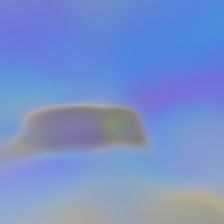
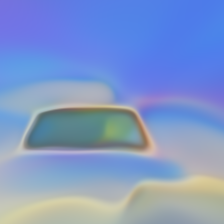
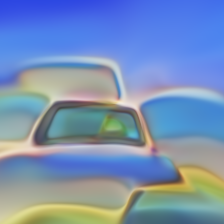
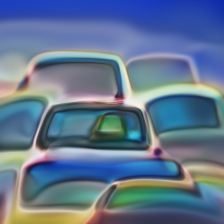
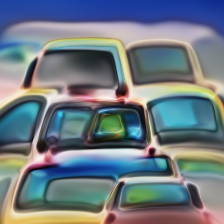

In [0]:
def render_feature(
    cppn_f = lambda: image_cppn(224),
    optimizer = tf.train.AdamOptimizer(0.005),
    objective = objectives.channel("mixed4b_3x3_pre_relu", 77)):
  vis = render.render_vis(model, objective, param_f=cppn_f, optimizer=optimizer, transforms=[], thresholds=[2**i for i in range(5,10)], verbose=False)
  show(vis)

render_feature()

### Varying the activation function


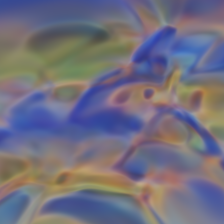
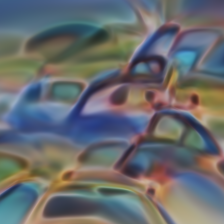
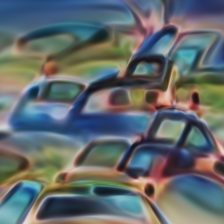
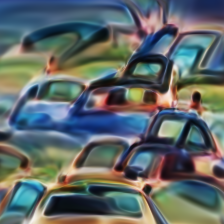
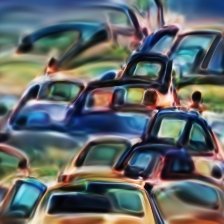

In [0]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=composite_activation_unbiased))


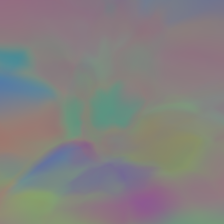
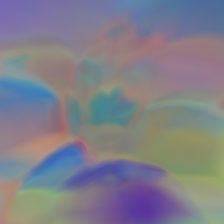
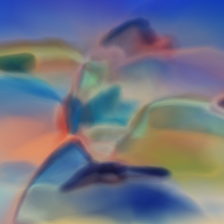
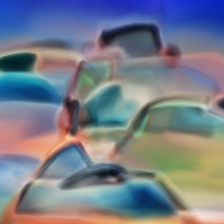
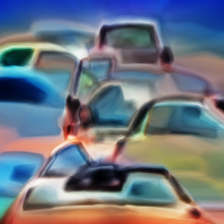

In [0]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=relu_normalized))


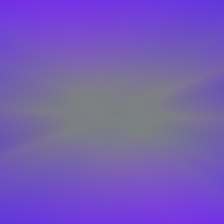
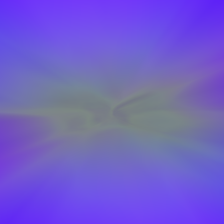
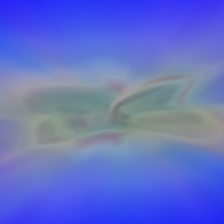
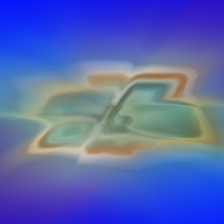
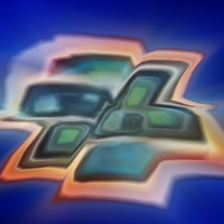

In [0]:
render_feature(
    cppn_f=lambda: image_cppn(224, activation_fn=tf.abs))

# Video of the training process

The following `render_story` function accomplishes a bunch of things: it sets up the optimization problem, saves out frames to a video at each step of the optimization, and finally saves out the weights and the final optimization result.

In [0]:
from lucid.misc.io.serialize_array import _normalize_array

def render_story(obj_str, lr=0.004, step_n=512,
                 normalize=False,
                 activation_fn=composite_activation):
  sess = create_session()

  # Set up optimization problem
  size = 224
  t_size = tf.placeholder_with_default(size, [])
  T = render.make_vis_T(
      model, obj_str, 
      param_f=lambda: image_cppn(
          t_size, normalize=normalize, activation_fn=activation_fn),
      transforms=[],
      optimizer=tf.train.AdamOptimizer(lr),
  )
  tf.global_variables_initializer().run()

  # Prepare video writer and filenames
  subst = {ord(':'):'_', ord('/'):'_'}
  out_name = 'xy2rgb_' + obj_str.translate(subst)
  video_fn = out_name + '.mp4'
  writer = FFMPEG_VideoWriter(video_fn, (size, size), 60.0)

  # Optimization loop
  try:
    for i in range(step_n):
      _, loss, img = sess.run([T("vis_op"), T("loss"), T("input")])
      writer.write_frame(_normalize_array(img))
      if i > 0 and i % 50 == 0:
        clear_output()
        print("%d / %d  score: %f"%(i, step_n, loss))
        show(img)
  except KeyboardInterrupt:
    pass
  finally:
    writer.close()

  # Show the resulting video
  clear_output()
  display(mpy.ipython_display(video_fn, height=400))

  # Save trained variables
  train_vars = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
  params = np.array(sess.run(train_vars), object)
  save(params, out_name + '.npy')

  # Save final image
  final_img = T("input").eval({t_size: 400})
  save(final_img, out_name+'.jpg', quality=90)

In [0]:
render_story('mixed4b_pool_reduce_pre_relu:16', )

In [0]:
render_story('mixed4a_pool_reduce_pre_relu:52')

### More interesting patterns to try

In [0]:
render_story('mixed4c_pool_reduce_pre_relu:5')

In [0]:
render_story('softmax0_pre_activation/matmul:316')

In [0]:
render_story('mixed4b_3x3_pre_relu:77')

In [0]:
render_story('mixed4d_3x3_bottleneck_pre_relu:114')

In [0]:
render_story('mixed4e_3x3_pre_relu:120')

In [0]:
render_story('head0_bottleneck_pre_relu:0')

In [0]:
render_story('mixed4d_3x3_bottleneck_pre_relu:139')

# Arbitrary resolution images

In [0]:
sess = create_session()
t_size = tf.placeholder_with_default(224, [])
t_image = image_cppn(t_size)

train_vars = sess.graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

def render_params(params, size=224):
  feed_dict = dict(zip(train_vars, params))
  feed_dict[t_size] = size
  return sess.run(t_image, feed_dict)[0]

  warnings.warn('An interactive session is already active. This can '




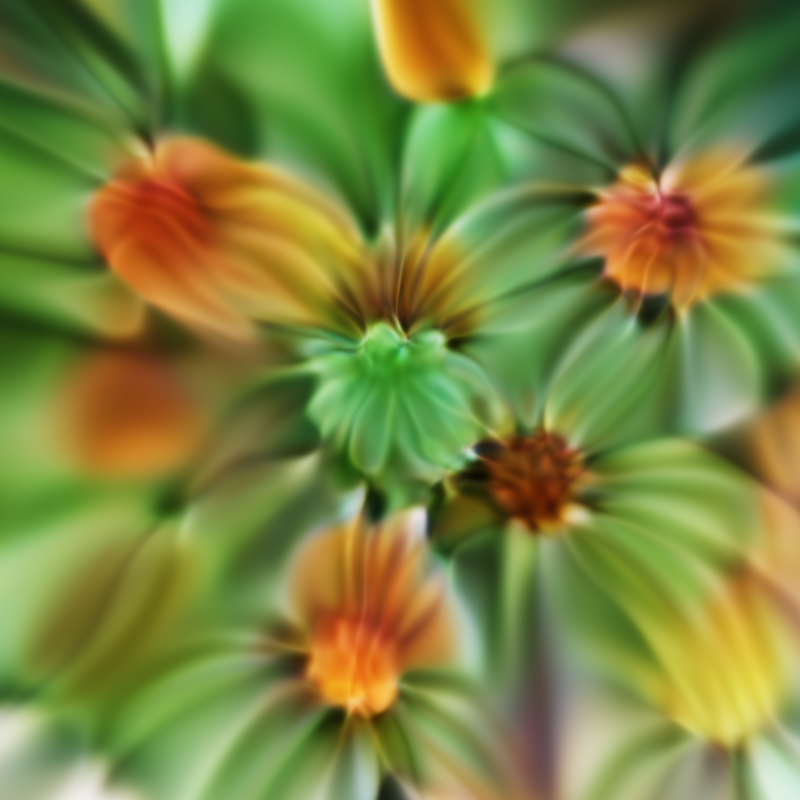

In [0]:
params = load('xy2rgb_mixed4b_pool_reduce_pre_relu_16.npy')
vis = render_params(params, 800)
show(vis)


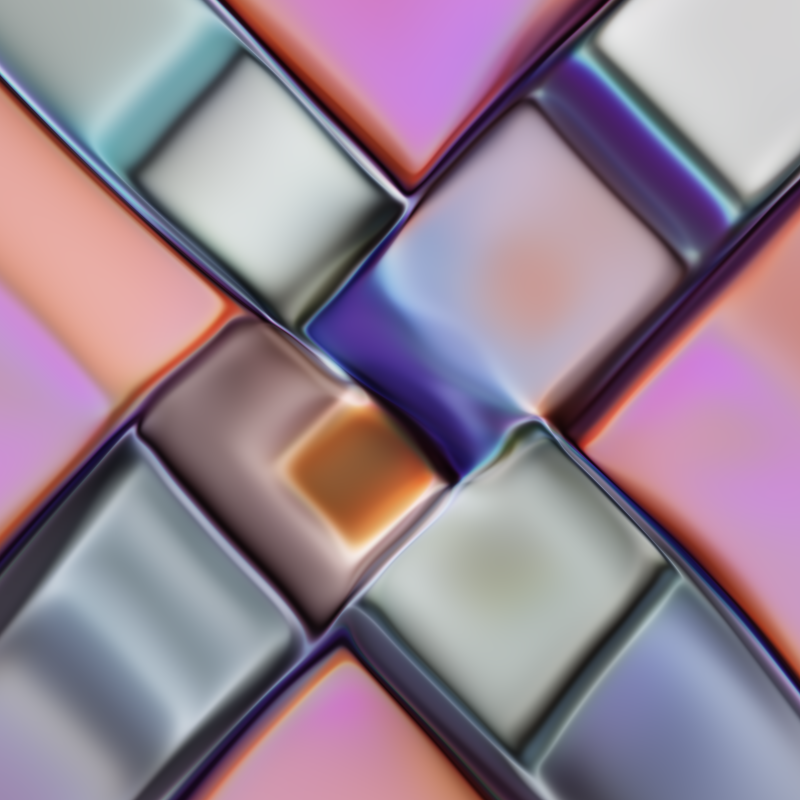

In [0]:
params = load('xy2rgb_mixed4a_pool_reduce_pre_relu_52.npy')
vis = render_params(params, 800)
show(vis)

# Interpolating CPPN parameters

This requires you to have run the `render_story` method from the "Video of the training process" section—it saves out the learned parameters which we are interpolating between here.

In [0]:
def interpolate_params(param1, param2, duration=5.0, size=224):

  def frame(t):
    t = t / duration
    t = (1.0-np.cos(2.0*np.pi*t))/2.0       # looping & easing
    params = param1*(1.0-t) + param2*t      # blending
    params *= 1.0 + t*(1.0-t)               # exaggerating
    img = render_params(params, size=size)
    return _normalize_array(img)

  clip = mpy.VideoClip(frame, duration=duration)
  clip.write_videofile('tmp.mp4', fps=30.0)
  display(mpy.ipython_display('tmp.mp4', height=400))

In [0]:
interpolate_params(
    load('xy2rgb_mixed4b_pool_reduce_pre_relu_16.npy'),
    load('xy2rgb_mixed4a_pool_reduce_pre_relu_52.npy'),
)

[MoviePy] >>>> Building video tmp.mp4
[MoviePy] Writing video tmp.mp4


 99%|█████████▉| 150/151 [00:01<00:00, 83.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: tmp.mp4 

